In [4]:
#!pip install scikit-learn


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import time

#imports for file handling
import os
import scipy
from scipy.sparse import save_npz
from scipy.sparse import load_npz
import json

# imports for data processing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Convert BVH to NPZ Files

BVH file is broken down into the joint hierarchy information and the local positions/rotations of the joints at each frame. For this, we only care about the local position of the joints and not the mapping of data to joint name of about converting the local coordinates to global coordinates.

"All joints are represented by local transforms
with respect to parent joints; a global pose of the pelvis is
provided with respect to a fixed frame"

In [9]:
#Don't need to rerun - used to create csv_data

#To tweak if we need to reduce the frame rate to 30FPS (which could farther reduce data with minimal impact on accuracy). 
#Since the default FP is 90, for every three consec. frames, I create a new frame with the value corresponding to some part being the value with maximum magnitude
# among the values of the same part across the three frames.

def convert_file(file_in, file_out, motion_param="acc", framerate30=False):
    """
    val_type specifies the data to be output, with choices of pos: position, acc: acceleration and vel: velocity
    framerate30 specifies whether the output should be 30FPS or the original 90FPS
    """
    file = open(file_in, "r")
    full_data = file.readlines()
    i = full_data.index("MOTION\n")
    num_frames = int(full_data[i+1].strip().replace("Frames: ", "")) #number of frames
    frame_time = float(full_data[i+2].strip().replace("Frame Time: ", "")) #duration of a single frame

    pos_data = [] # frame [ 83 joints [xpos, ypos, zpos, zrot, xrot, yrot]]]
    if not framerate30:
        for frame in full_data[i+3:]:
            pos_data.append( [float(x) for x in frame.split()])

    else: #reduce from 90 FPS to 30 FPS
        frame_time *= 3
        val_max_magnitude = lambda x1, y1 : x1 if abs(x1) > abs(y1) else y1
        x  = 0
        new_frame_data = []
        while i+3+x < len(full_data):
            if not new_frame_data:
                new_frame_data = [float(el) for el in full_data[i+3+x].split()]
            else:
                new_frame = full_data[i+3+x].split()
                new_frame_data = [val_max_magnitude(float(new_frame[j]), new_frame_data[j]) for j in range(len(new_frame_data))]
                if x%3 == 0:
                    pos_data.append(new_frame_data)
                    new_frame_data = []
            x += 1

    # take the derivative to get acceleration
    pos_data = np.array(pos_data)
    
    #whether to write position, acceleration or velocity data to file
    if motion_param == "acc":
        motion_data = np.diff(pos_data, 2, 0)
    elif motion_param == "vel":
        motion_data = np.diff(pos_data, 1, 0)
    elif motion_param == "pos":
        motion_data = pos_data
    else:
        raise ValueError("val_type is one of: `acc`: acceleration, `vel`: velocity, or `pos`: position")

    
    # How much does taking the derivative reduce the amount of non zero data?
    #total_size = np.size(pos_data)
    # print(total_size , round(np.count_nonzero(pos_data)/total_size*100,4), round(np.count_nonzero(acc_data)/total_size*100, 4))
    # ~ 70 -> 20%
    
    # cut out the first ~5 seconds on each side of the take to remove weird artifacts
    acc_data = motion_data[500: -500]
    sparse_data = scipy.sparse.csr_matrix(motion_data)
    save_npz(file_out, sparse_data)
    # TODO - is there a better way to store this that capitalizes on the sparsity?
    
    file.close()
    return len(motion_data), frame_time

In [11]:
# For each BVH file, clean up the file structure and write out the local motion
start_time = time.time()
data_dir = "mocap_data"

frames = []
frame_length = []
people_pairs = {} #maps a pair of people to 2 files with their mocap data during their conversation

# iterate through the session directories
for session_dir in [x for x in os.listdir(data_dir) if x.startswith("session")]:
    session_path = os.path.join(data_dir, session_dir)
    for take_dir in [x for x in os.listdir(session_path) if x.startswith("take")]:
        # reformat file structure so all info if in file name so we don't have to recurse later
        take_path = os.path.join(session_path, take_dir)
        file_a, file_b =  [x for x in os.listdir(take_path) if ".bvh" in x]
        # Get file path for each of the bvh files
        person_a = file_a.replace(take_dir + "_hasFingers_", "").replace("_scale_local.bvh", "")
        person_b = file_b.replace(take_dir + "_hasFingers_", "").replace("_scale_local.bvh", "")
        # Convert the bvh file to a npz file with sparse acceleration data
        new_a = "npz_take_data/" + person_a + "_" + person_b + "_" + session_dir.replace("ession", "") + take_dir.replace("ake", "") + '.npz'
         
        #f, f_len = convert_file(os.path.join(take_path, file_a), new_a)
        f, f_len = convert_file(os.path.join(take_path, file_a), new_a, motion_param="pos", framerate30=True)
        frames.append(f)
        frame_length.append(f_len)

        # # Exact same thing but for person b           
        new_b = "npz_take_data/" + person_b + "_" + person_a + "_" + session_dir.replace("ession", "") + take_dir.replace("ake", "") + '.npz'
        #f, f_len = convert_file(os.path.join(take_path, file_b), new_b)
        f, f_len = convert_file(os.path.join(take_path, file_b), new_b, motion_param="pos", framerate30=True)
        people_pairs[(person_a, person_b)] = (new_a, new_b)
        frames.append(f)
        frame_length.append(f_len)
        
print("Time to complete (mins): ", (time.time()-start_time)/60)

Time to complete (mins):  10.22048728466034


In [12]:
# Are all frames captured at the same frame rate?
if (len(set(frame_length)) == 1):
    print("All frame rates are the same: ", frame_length[0])
else:
    print("ERROR: Need to account for differnces in frame rate")
          
print("Total data (minutes): ", sum(frames)*frame_length[0]/60)
shortest_take = np.min(frames)
print("Shortest take: ", shortest_take)
print("Longest take (relative to shortest): ", np.max(frames)/np.min(frames))


All frame rates are the same:  0.033333333333300005
Total data (minutes):  508.3477777772695
Shortest take:  2075
Longest take (relative to shortest):  17.112289156626506


# Load in Take data to create full data matrix

Average Interperson Covariance 


In [55]:
#Computes the interperson covariance per pair of people

# Frames are sampled per conversation ---> any thoughts on this?
#Then less useful joints are removed
import random
def get_sample_matrix(person1, person2, n):
    """
    person1: speaker and person2: listener so that (person1, person2) is in people_pairs dictionary
    n: the number of frames
    Returns two matrices of sampled frames from the conversation of person1 and person2 in that order
    """
    file1, file2 = people_pairs[(person1, person2)]
    person1_frames, person2_frames = load_npz(file1).toarray(), load_npz(file2).toarray()
    
    #normalize the data by subtracting the column mean and dividing by the column standard deviation, prevent division by 0
    person1_frames = (person1_frames - np.mean(person1_frames, axis=0))/(np.std(person1_frames, axis=0) + 1e-10)
    person2_frames = (person2_frames - np.mean(person2_frames, axis=0))/(np.std(person2_frames, axis=0) + 1e-10)
    
    #randomly sample n frames
    sampled_indices = random.sample(range(person1_frames.shape[0]), n)
    p1_frames = person1_frames[sampled_indices]
    p2_frames = person2_frames[sampled_indices]
    #sum every 6 values in the columns to have columns/6 values per row
    return person1_frames[sampled_indices], person2_frames[sampled_indices]


def remove_some_joints(matrix): #is this necessary?
    #CAREFUL, may change animation
    pass

    

(83, 83)


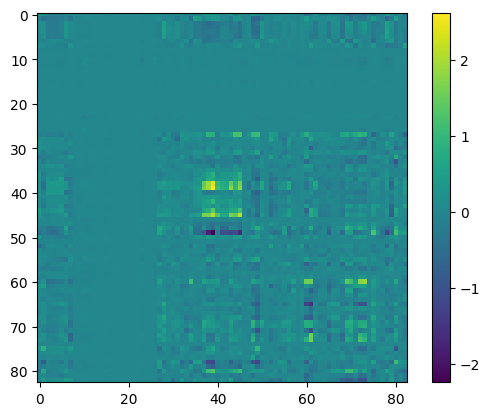

In [57]:
#Compute average interperson covariance matrix
num_sample_frames = 10
interperson_cov_matrix = None
for (p1, p2) in people_pairs:
    p1_matrix, p2_matrix = get_sample_matrix(p1, p2, num_sample_frames)
    for i in range(num_sample_frames):
        if interperson_cov_matrix is None:
            interperson_cov_matrix = np.outer(p1_matrix[i], p2_matrix[i])
        else:
            interperson_cov_matrix += np.outer(p1_matrix[i], p2_matrix[i])
interperson_cov_matrix /= (len(people_pairs) * num_sample_frames)
#summing covariances for each joint
interperson_cov_matrix = np.sum(interperson_cov_matrix.reshape(-1, 6, interperson_cov_matrix.shape[1]), axis=1)
interperson_cov_matrix = np.sum(interperson_cov_matrix.reshape(interperson_cov_matrix.shape[0], -1, 6), axis=2)
print(interperson_cov_matrix.shape)
#Plotting the interperson covariance matrix
import matplotlib.pyplot as plt
plt.imshow(interperson_cov_matrix)
plt.colorbar()
plt.show()
#to improve by removing some joints and visualizing only joints with higher covariance and comparing
#a mapping from index of joints to names of joints would be useful

In [30]:
#Chunking the data
start_time = time.time()

data = []
l = shortest_take # Number of frames in the shortest take, 56 files
speakers = []
listeners = []

# format data so that each column is a
for file in [x for x in os.listdir("npz_take_data") if ".npz" in x]:
    info = file.split("_")
    d = load_npz(os.path.join("npz_take_data", file)).toarray() # convert back to numpy to handle
    for i in range(d.shape[0]//l): # use numpy reshape instead??
        chunk = np.array(d[i*l: (i+1)*l]).flatten()
        speakers.append(info[0])
        listeners.append(info[1])
        data.append(chunk) # using numpy is slooowwww
            
print(time.time() - start_time)

25.00690484046936


Save / Load from files as needed

In [31]:
import json

In [32]:
start_time = time.time()
#Write out to file
data = np.transpose(np.array(data)) # each column is a series of accelerations from within a take
print(data.shape)
sparse_data =  scipy.sparse.csr_matrix(data)
print("is this the slow part?  ", (time.time() - start_time)/60)
save_npz('sparse_data.npz', sparse_data)

with open('pair_ids.json', 'w') as f:
    json.dump({"speakers": speakers, "listeners": listeners}, f)
     
print((time.time() - start_time)/60) # should run in ~ 

(2602548, 492)


In [33]:
start_time = time.time()
# Reload if needed
data = load_npz('sparse_data.npz').toarray()

with open('pair_ids.json', 'r') as f:
    x = json.load(f)
    speakers = x['speakers']
    listeners = x['listners']
    
print((time.time() - start_time)/60) # should run in ~

0.24578799804051718


### Speaker vs. Data Distribution

What is the actual breakdown of number of chunks for each speaker pair? For each speaker?

Total chunks:  492
Total data length (hrs):  7.9349842


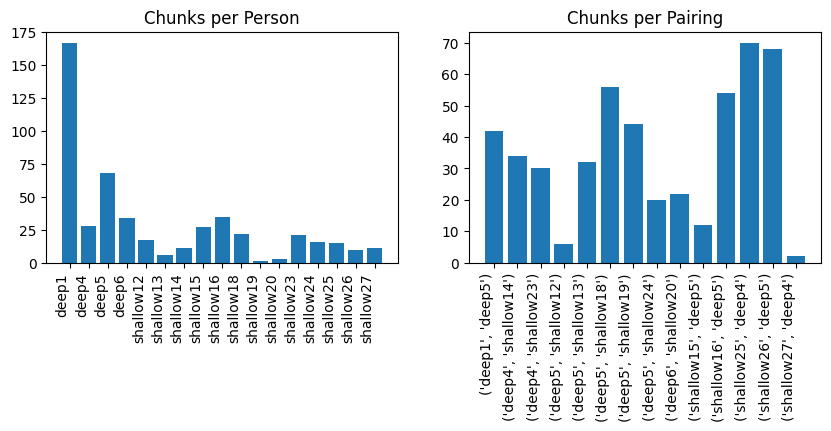

In [34]:
# create a dictionary of counts for each (speaker, listener) pair
print("Total chunks: ", len(speakers))
print("Total data length (hrs): ", ((len(speakers)*5226*0.01111)/60)/60) #frames per chunk, and frames per second
pairs = {}
speaker_freq = {}
for i, speaker in enumerate(speakers):
    listener = listeners[i]
    # Track how many chunks for each person
    if speaker in speaker_freq:
        speaker_freq[speaker] += 1
    else:
        speaker_freq[speaker] =1
    # Track how many chunks for each pair of people
    if (speaker, listener) in pairs:
        pairs[(speaker, listener)] += 1
    elif (listener, speaker) in pairs:
        pairs[(listener, speaker)] += 1
    else:
        pairs[(speaker, listener)] = 1

# get the unique pairs of speakers and listeners
#Is the relationship assymetric?
unique_pairs = sorted(set(pairs.keys()))
unique_people = sorted(set(speaker_freq.keys()))

# create a list of counts for each unique pair of speakers and listeners
pairs_list = [pairs[pair] for pair in unique_pairs]
people_count = [speaker_freq[x] for x in speaker_freq]

# set up the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# create the left bar chart
axs[0].bar(np.arange(len(unique_people)), people_count)
axs[0].set_xticks(np.arange(len(unique_people)))
axs[0].set_xticklabels(unique_people, rotation=90, ha="right")
axs[0].set_title("Chunks per Person")

# create the right bar chart
axs[1].bar(np.arange(len(unique_pairs)), pairs_list)
axs[1].set_xticks(np.arange(len(unique_pairs)))
axs[1].set_xticklabels(unique_pairs, rotation=90, ha="right")
axs[1].set_title("Chunks per Pairing")

plt.show()

## Is there any other preprocessing that we need to do - normalization or otherwise?

## TOD0
1) PCA on just 3 dimensions for quick check
    - Add color to output to see if there are already trends

1) SVD of full data - what is the actually dimensionality?
2) PCA with n_componenets = n (where n is determined by singulr values from part a) -> reduced dimensionality data
3) Use reduced data to create covariance matrix.
    Plot both covariance of all chunks
    But also average covariance of each pairing (including pairing with self)
    - We should see stronger covariance between one person and themselves
    Maybe also look at the covariance of each pairing as a function of time, do they get more similar the longer they talk?
4) Compare average speaker a, to average speaker b, and to average of speaker a spearking to b

In [37]:
# Should take ~13 seconds
start_time = time.time()
sparse_data = load_npz('sparse_data.npz').toarray()
print(time.time()-start_time)
print(sparse_data.shape)

10.283396244049072
(2602548, 492)


In [36]:
# reduce down to subset of features - Takes 10 minutes if the wrong way, 2-4min the correct way
start_time = time.time()
pca = PCA(n_components=3)
pca_feats = pca.fit_transform(data)
print((time.time()-start_time)/60)
print(pca_feats.shape)

3.798800746599833
(2602548, 3)


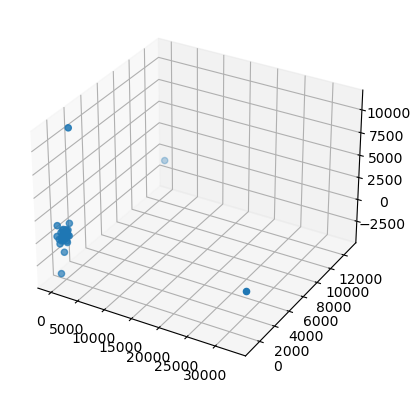

In [ ]:
# TODO: Add color coding

# create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot the points
ax.scatter(pca_feats[:,0], pca_feats[:,1], pca_feats[:,2])
# show the plot
plt.show()


#each row is a frame
#each frame is a row, col = joints by 6 location

(526,)


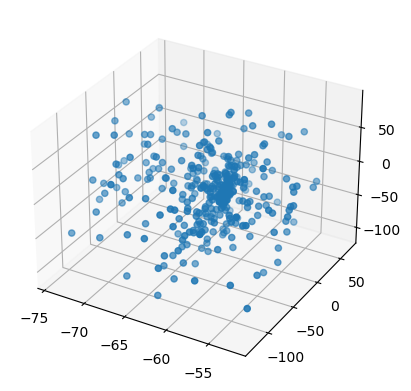

In [ ]:
# create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# find the quartiles for each dimension
pca_feats_sorted = np.sort(pca_feats, axis=0)
n = pca_feats_sorted.shape[0]
q1 = pca_feats_sorted[n // 4]
q3 = pca_feats_sorted[n // 4 * 3]

# compute the interquartile range for each dimension
iqr = q3 - q1

# define the lower and upper bounds for outliers
lb = q1 - 1.5 * iqr
ub = q3 + 1.5 * iqr

# identify the outliers
outliers = np.logical_or(pca_feats < lb, pca_feats > ub)
outliers = np.any(outliers, axis=1) 
print(outliers.shape)

# plot the non-outliers
x = pca_feats[:, 0][~outliers]
y = pca_feats[:, 1][~outliers]
z = pca_feats[:, 2][~outliers]
ax.scatter(x, y, z)

# show the plot
plt.show()


In [39]:
#The structure of the matrix up to this point is such that:
#    - rows correspond to frames
#    - columns correspond to velocity of a joint in some direction i.e 6 directions per joint

#The meaning of PCA here would be the correlation between frames and joint directions. So PCA is not meaningful unless the representation is changed

In [ ]:
#SVD
#Assumes the data is in a form that is meaningful, and dimensions m, n are not too big
print(data.shape)
U, Sigma, V = np.linalg.svd(data, full_matrices=False)

#Transforming data with the SVD components
data_svd = np.dot(data, np.diag(Sigma))



In [ ]:
#PCA with n components
